In [1]:
import pprint
import time
from pathlib import Path

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
from hydra import compose, initialize
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from sklearn.model_selection import StratifiedKFold

from src.seed import seed_everything


with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


lgb:
  params:
    objective: binary
    metric: auc
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.01
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 50
    bagging_fraction: 0.8
    bagging_freq: 1
    feature_fraction: 0.8
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
exp_number: '020'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  clothing_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/020/base
seed: 42
n_splits: 5
target: Recommended IND



In [2]:
train_df = pd.read_csv(cfg.data.train_path)
clothing_df = pd.read_csv(cfg.data.clothing_path)
test_df = pd.read_csv(cfg.data.test_path)
all_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)


In [3]:
sub_df = pd.read_csv("/workspace/results/017/20240831_072501/20240831_072501_submission2.csv")


<Axes: >

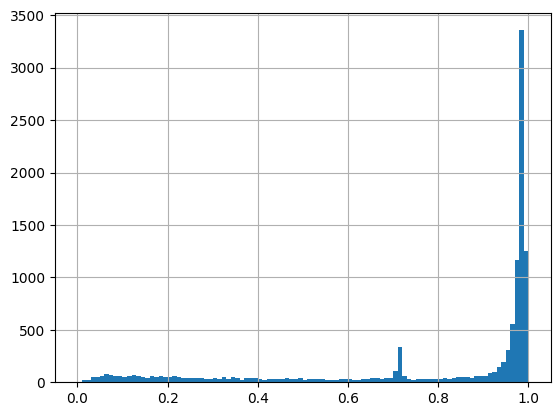

In [4]:
sub_df["target"].hist(bins=100)


In [5]:
for c, count in all_df["Title"].value_counts()[:30].to_dict().items():
    target_mean = train_df[train_df["Title"] == c][cfg.target].mean()

    if target_mean != 1:
        print(f"No:{c}")
        continue
    index = test_df[test_df["Title"] == c].index
    sub_df.loc[index, "target"] = 1

    print(c)


No:Love it!
No:Beautiful
Love
Love!
Beautiful!
Beautiful dress
Love it
No:Disappointed
Love this dress!
Gorgeous
Cute top
Great dress
Perfect
Great top
Super cute
Adorable
No:Not for me
Great dress!
Beautiful top
No:Disappointing
Great top!
No:Runs small
Perfect!
Cute
Love this dress
Lovely
Love this top
Cute!
Beautiful dress!
No:Love this top!


<Axes: >

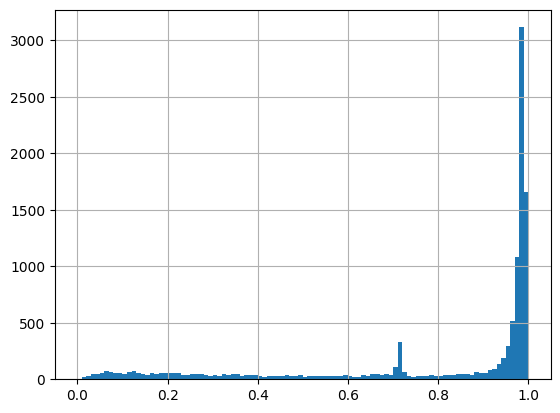

In [6]:
sub_df["target"].hist(bins=100)


In [7]:

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
